# How to use multi-class logistic classification model to predict which district a crime is likely to occur using Chicago Crime data in BigQueryML

###### Copyright
**Notebook Author:** [Paul Kamau](https://paulkamau.com)<br>
**Project Type:** BQML Logistic Reg<br>
**Date created:** 2022/12/10<br>
**Description:** Predict the crime district in Chicago with multi-class logistic regression<br>
**Training Dataset** This project uses the public dataset[`Chicago Crime`](https://cloud.google.com/bigquery?sq=1057666841514:f29282e50d984f96a6fa3395aa080abf&_ga=2.187413480.-1379782407.1673021064&project=paulkamau&ws=!1m4!1m3!3m2!1s1057666841514!2schicago_crime) has about 7,713,765
 rows of data.

## Summary
The pupose of this project is to use a multi-class logistic regression model in BigQuery ML to make a prediction (yes/no) for arrests in the Chicago Crime Data set Census Dataset from 2001 to 2023.

The model will predict whether a Crime resulted in an arrest using  the arrest falls into one of **24 categories** based on the crime data attributes

### Dataset
The public dataset [`Chicago Crime`](https://cloud.google.com/bigquery?sq=1057666841514:f29282e50d984f96a6fa3395aa080abf&_ga=2.187413480.-1379782407.1673021064&project=paulkamau&ws=!1m4!1m3!3m2!1s1057666841514!2schicago_crime) has about 7,713,765
 rows of data.

### Key Concepts
- BigQuery
- BigQuery ML
- Dimensionality Reduction
- Vertex AI Model Registry
- Vertex endpoints
- Logistic regression
- Explainable AI
- ML.EVALUATE
- ML PREDICT

### Steps
1. Create the dataset
1. Use the SELECT statement to examine the data
1. Use the CREATE VIEW statement to compile your training data
1. Use the CREATE MODEL statement to create your logistic regression model.
1. Use the ML.EVALUATE function to evaluate the model data
1. Use the ML.PREDICT function to predict the income bracket for a given set of census participants.
1. Use the ML.EXPLAIN_PREDICT function to explain prediction results with explainable AI Methods.
1. Use the ML.GLOBAL_EXPLAIN function to know which features are the most important to determine the income bracket.


## Prepare the Envrionment with Package Installs
1. Install the following packages required to execute this notebook.
1. install the workbench notebook product dependencies
1. Automatically restart kernel after installs

### Import AI Platform and ML libraries

In [1]:
import os
import sys

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform {USER_FLAG} -q google-cloud-bigquery db-dtypes

#### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [2]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Prepare the notebook to run in colab.

In [2]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.
import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

#### Import the Google Cloud SDK packages

In [3]:
import google.cloud.aiplatform as vertex_ai
import pandas as pd
import matplotlib.pyplot as plt
import json

from typing import Union  # This module provides runtime support for type hints
from google.cloud import bigquery
from sklearn import metrics
from google.api import httpbody_pb2

print("All imports complete")

All imports complete


#### GCP & BQML Variables

In [4]:
# Project variables
#
# These are the project variable used in this ML Model:
#

PROJECT_ID = "" # @param {type:"string"}
SERVICE_ACCOUNT = ""

BQML_MODEL_TYPE = "LOGISTIC_REG" #@param ["LINEAR_REG", "LOGISTIC_REG","KMEANS","PCA","MATRIX_FACTORIZATION","AUTOENCODER","AUTOML_REGRESSOR", "AUTOML_CLASSIFIER","BOOSTED_TREE_CLASSIFIER","BOOSTED_TREE_REGRESSOR","RANDOM_FOREST_CLASSIFIER","RANDOM_FOREST_REGRESSOR", "DNN_CLASSIFIER","DNN_REGRESSOR","DNN_LINEAR_COMBINED_CLASSIFIER", "DNN_LINEAR_COMBINED_REGRESSOR","ARIMA_PLUS","TENSORFLOW"]
BQML_MODEL_NAME = "bqml_log_reg_chicago_crime_district_predict_model"
BQML_JOB_DISPLAY_NAME = BQML_MODEL_NAME + "_job"
BQML_ENDPOINT_NAME = BQML_MODEL_NAME + "_endpoint"
BQML_DEPLOYMENT_NAME = BQML_MODEL_NAME + "_deployment"

# datasets
BQ_DATASET_NAME = BQML_MODEL_NAME + "_dataset"
BQ_PUBLIC_DATASET = "1057666841514.chicago_crime.crime"
BQ_DATASET_VIEW_TABLE= f"{BQ_DATASET_NAME}.input_view"

# bucket details
BUCKET_NAME = "bigquery_ml_tutorials"
BUCKET_URI = f"gs://{BUCKET_NAME}/{BQML_MODEL_TYPE}/{BQML_MODEL_NAME}"
OUTPUTBUCKET = f"gs://bqml_datasets_predictions/{BQML_MODEL_TYPE}/"

# Region
REGION = "us-central1" #@param ["us-central1", "europe-west4", "asia-east1"]

print("All variables set")

All variables set


#### Set the Service account automatically from gcloud

In [ ]:
# Get your service account from gcloud
if not IS_COLAB:
    shell_output = !gcloud auth list 2>/dev/null
    SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

else:  # IS_COLAB:
    shell_output = ! gcloud projects describe  $PROJECT_ID
    project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
    SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

print("Service Account:", SERVICE_ACCOUNT)

#### Initialize Vertex AI and BigQuery SDKs for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [5]:
vertex_ai.init(project=PROJECT_ID, location=REGION)
bq_client = bigquery.Client(project=PROJECT_ID)

print("vertex and BQ initialized")

vertex and BQ initialized


Use a helper function for sending queries to BigQuery.

In [6]:
# Wrapper to use BigQuery client to run query/job, return job ID or result as DF
def run_bq_query(sql: str) -> Union[str, pd.DataFrame]:
    """
    Input: SQL query, as a string, to execute in BigQuery
    Returns the query results as a pandas DataFrame, or error, if any
    """

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df

print("BQ wrapper set")

BQ wrapper set


# Using BigQuery ML logistic regression model for arrest prediction classification on census data

BigQuery ML (BQML) provides the capability to train ML tabular models, such as classification, regression, forecasting, and matrix factorization, in BigQuery using SQL syntax directly. BigQuery ML uses the scalable infrastructure of BigQuery ML so you don't need to set up additional infrastructure for training or batch serving.

#### **Commentary**:
The dataset [`Chicago Crime`](https://cloud.google.com/bigquery?sq=1057666841514:f29282e50d984f96a6fa3395aa080abf&_ga=2.187413480.-1379782407.1673021064&project=paulkamau&ws=!1m4!1m3!3m2!1s1057666841514!2schicago_crime) has about 7,713,765 rows of data from 2001 to 2023.



### Step 1: Create Your Dataset
BigQuery organizes data tables into units called datasets. These datasets are scoped to your GCP project. Datasets are:

[Dataset SDK Reference](https://cloud.google.com/bigquery/docs/datasets-intro)

In [7]:
# check if Dataset exists.
sql_list_dataset_exists = f"""SELECT count (*) FROM INFORMATION_SCHEMA.SCHEMATA WHERE schema_name = '{BQ_DATASET_NAME}'"""

# Display the sql statement
print(sql_list_dataset_exists)

# execute the sql statement
run_bq_query(sql_list_dataset_exists)

if sql_list_dataset_exists != 0:
    print("Dataset exists")
    print(f'Review the Dataset in the Console:\nhttps://console.cloud.google.com/bigquery?page=dataset&p={PROJECT_ID}&d={BQ_DATASET_NAME}&project={PROJECT_ID}')
else:
  print("dataset doesn't exist")


SELECT count (*) FROM INFORMATION_SCHEMA.SCHEMATA WHERE schema_name = 'bqml_log_reg_chicago_crime_district_predict_model_dataset'
Finished job_id: 64d1b549-8a2c-41b2-a3ea-84645959d85c
Dataset exists
Review the Dataset in the Console:
https://console.cloud.google.com/bigquery?page=dataset&p=paulkamau&d=bqml_log_reg_chicago_crime_district_predict_model_dataset&project=paulkamau


In [8]:
sql_create_dataset = f"""CREATE SCHEMA IF NOT EXISTS {BQ_DATASET_NAME}"""

print(sql_create_dataset)

run_bq_query(sql_create_dataset)

print(f'Review the Dataset in the Console:\nhttps://console.cloud.google.com/bigquery?page=dataset&p={PROJECT_ID}&d={BQ_DATASET_NAME}&project={PROJECT_ID}')

CREATE SCHEMA IF NOT EXISTS bqml_log_reg_chicago_crime_district_predict_model_dataset
Finished job_id: 825b631e-da9b-413f-a6a4-7f9be64f7696
Review the Dataset in the Console:
https://console.cloud.google.com/bigquery?page=dataset&p=paulkamau&d=bqml_log_reg_chicago_crime_district_predict_model_dataset&project=paulkamau


Inspect data that has been pre-processed from  [`Chicago Crime`](https://cloud.google.com/bigquery?sq=1057666841514:f29282e50d984f96a6fa3395aa080abf&_ga=2.187413480.-1379782407.1673021064&project=paulkamau&ws=!1m4!1m3!3m2!1s1057666841514!2schicago_crime) with about 7,713,765 rows of data from 2001 to 2023.

The data view results show that the **``location_description``** column in the chicago_crime table has one of **216 categories** values.



In [9]:
sql_inspect_full_feature_dataset = f"""
SELECT *
FROM
`{BQ_PUBLIC_DATASET}`
LIMIT
 10;
"""

sql_inspect_record_count_dataset = f"""
SELECT count(*)
FROM
 `{BQ_PUBLIC_DATASET}`
"""

# Display the sql statement
print(sql_inspect_full_feature_dataset)
print(run_bq_query(sql_inspect_record_count_dataset))
run_bq_query(sql_inspect_full_feature_dataset)



SELECT *
FROM 
`1057666841514.chicago_crime.crime`
LIMIT
 10;

Finished job_id: 35168fb8-a543-422a-946d-99e3732afa14
       f0_
0  7714399
Finished job_id: a25e6be5-ddbf-47dc-98f1-aa7c8d0b67e8


,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,26284,JE372655,2021-09-14 01:23:00+00:00,002XX W 107TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,PORCH,False,False,...,34,49,01A,1176374.0,1833981.0,2021,2022-08-31 04:51:30+00:00,41.699793,-87.629808,"(41.699793149, -87.629807603)"
1,5001,HR298598,2009-05-02 03:15:00+00:00,105XX S WABASH AVE,0110,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,False,False,...,9,49,01A,1178438.0,1835159.0,2009,2022-09-18 04:45:51+00:00,41.702979,-87.622215,"(41.702979231, -87.622214525)"
2,5041,HR349953,2009-05-31 02:00:00+00:00,105XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,9,49,01A,1179452.0,1834941.0,2009,2022-09-18 04:45:51+00:00,41.702358,-87.618508,"(41.702357973, -87.618508148)"
3,1933,HH849690,2002-12-20 06:00:00+00:00,007XX E 104TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,ALLEY,False,False,...,9,50,01A,1182896.0,1836154.0,2002,2022-09-18 04:45:51+00:00,41.705607,-87.605860,"(41.705607465, -87.60585975)"
4,19706,HS649337,2010-12-07 07:35:00+00:00,104XX S MICHIGAN AVE,0110,HOMICIDE,FIRST DEGREE MURDER,ABANDONED BUILDING,False,False,...,9,49,01A,1178889.0,1835859.0,2010,2022-09-18 04:45:51+00:00,41.704890,-87.620542,"(41.704889896, -87.620541865)"
5,22150,HY466381,2015-10-18 02:07:00+00:00,106XX S PRAIRIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,...,9,49,01A,1179795.0,1834569.0,2015,2022-08-31 04:51:30+00:00,41.701329,-87.617264,"(41.701329334, -87.61726351)"
6,22637,HZ361128,2016-07-23 03:37:00+00:00,104XX S WENTWORTH AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,34,49,01A,1176803.0,1835516.0,2016,2022-09-18 04:45:51+00:00,41.703996,-87.628191,"(41.703995782, -87.628190772)"
7,6900126,HR306437,2009-05-06 12:00:00+00:00,0000X E 103RD PL,0261,CRIM SEXUAL ASSAULT,AGGRAVATED: HANDGUN,VEHICLE NON-COMMERCIAL,False,False,...,9,49,02,1178184.0,1836354.0,2009,2016-02-04 06:33:39+00:00,41.706264,-87.623109,"(41.706264228, -87.623108519)"
8,10632309,HZ384555,2016-08-09 08:30:00+00:00,005XX E 104TH PL,0261,CRIM SEXUAL ASSAULT,AGGRAVATED: HANDGUN,ALLEY,False,False,...,9,49,02,1181956.0,1835794.0,2016,2018-02-10 03:50:01+00:00,41.704641,-87.609313,"(41.704641317, -87.609312999)"
9,9970506,HY160321,2015-02-22 02:00:00+00:00,001XX E 107TH ST,0265,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - OTHER,APARTMENT,False,False,...,9,49,02,1179283.0,1834056.0,2015,2021-08-12 04:59:32+00:00,41.699933,-87.619154,"(41.699933258, -87.619153849)"


### Dataset column variables

#### **Commentary**:
The SQL above brings back all the features (columns) in the dataset. Not every column is going to be useful for our modeling.

**Data preparation **is required to remove duplicates, unecessary data or noise from the dataset.

The final columns (features) used for prediction are called **inputs**.

The prediction column, in this case, `location_description`, is called **Label**. This is the purpose of this logistic classifiaction model. We'll rename this column to "**crime_scene**"

The number of **input variables** or **features** for a dataset is referred to as its dimensionality. *(See all the columns from the sql above)*

**Dimensionality reduction** refers to techniques that reduce the number of input variables in a dataset (See all the columns from the sql below)

In [11]:
## Dataset variables
MODEL_FEATURE_COLUMNS = "unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location"
MODEL_INPUT_COLUMNS = "district,location_description,arrest,date,block,primary_type,description,domestic,beat,ward,community_area,fbi_code,year"
MODEL_DROPPED_COLUMNS = "unique_key,iucr,case_number,updated_on,updated_on,latitude,longitude,location"
MODEL_LABEL_PREDICTION = 'district'
print('All dataset column selections updated')

All dataset column selections updated


#### These will be our input columns and data for the model we're building

In [12]:
sql_inspect_dataset = f"""
SELECT
 {MODEL_INPUT_COLUMNS},
FROM
 `{BQ_PUBLIC_DATASET}`
LIMIT
 10;
"""

# Display the sql statement
print(sql_inspect_dataset)

# Run the query
run_bq_query(sql_inspect_dataset)


SELECT
 district,location_description,arrest,date,block,primary_type,description,domestic,beat,ward,community_area,fbi_code,year,
FROM
 `1057666841514.chicago_crime.crime`
LIMIT
 10;

Finished job_id: 98b5721d-e2dc-4192-b546-ca74765654d4


,district,location_description,arrest,date,block,primary_type,description,domestic,beat,ward,community_area,fbi_code,year
0,5,PORCH,False,2021-09-14 01:23:00+00:00,002XX W 107TH ST,HOMICIDE,FIRST DEGREE MURDER,False,512,34,49,01A,2021
1,5,APARTMENT,False,2009-05-02 03:15:00+00:00,105XX S WABASH AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,9,49,01A,2009
2,5,STREET,False,2009-05-31 02:00:00+00:00,105XX S INDIANA AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,9,49,01A,2009
3,5,ALLEY,False,2002-12-20 06:00:00+00:00,007XX E 104TH ST,HOMICIDE,FIRST DEGREE MURDER,False,512,9,50,01A,2002
4,5,ABANDONED BUILDING,False,2010-12-07 07:35:00+00:00,104XX S MICHIGAN AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,9,49,01A,2010
5,5,AUTO,False,2015-10-18 02:07:00+00:00,106XX S PRAIRIE AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,9,49,01A,2015
6,5,STREET,False,2016-07-23 03:37:00+00:00,104XX S WENTWORTH AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,34,49,01A,2016
7,5,VEHICLE NON-COMMERCIAL,False,2009-05-06 12:00:00+00:00,0000X E 103RD PL,CRIM SEXUAL ASSAULT,AGGRAVATED: HANDGUN,False,512,9,49,02,2009
8,5,ALLEY,False,2016-08-09 08:30:00+00:00,005XX E 104TH PL,CRIM SEXUAL ASSAULT,AGGRAVATED: HANDGUN,False,512,9,49,02,2016
9,5,APARTMENT,False,2015-02-22 02:00:00+00:00,001XX E 107TH ST,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - OTHER,False,512,9,49,02,2015


### Step 2: Use the CREATE VIEW statement to compile the training data

The next step was to create a view that compiles the training data. This was done by selecting the data used to train your logistic regression model.

A **view** is a virtual table defined by a SQL query. When you create a view, you query it in the same way you query a table. When a user queries the view, the query results contain data only from the tables and fields specified in the query that defines the view.

The census respondent income prediction is done based on the following attributes:

In [13]:
# Create the dataset view if it doesn't exist
sql_create_dataset_view_bqml = f"""
CREATE VIEW IF NOT EXISTS `{BQ_DATASET_NAME}.input_view` AS
SELECT
{MODEL_INPUT_COLUMNS},
 CASE
   WHEN MOD(year, 10) < 8 THEN 'training'
   WHEN MOD(year, 10) = 8 THEN 'evaluation'
   WHEN MOD(year, 10) = 9 THEN 'prediction'
 END AS dataframe
FROM
 `{BQ_PUBLIC_DATASET}`
 WHERE {MODEL_LABEL_PREDICTION} is not null;
"""

# Display the sql statement
print(sql_create_dataset_view_bqml)

# Run the query
run_bq_query(sql_create_dataset_view_bqml)


CREATE VIEW IF NOT EXISTS `bqml_log_reg_chicago_crime_district_predict_model_dataset.input_view` AS
SELECT
district,location_description,arrest,date,block,primary_type,description,domestic,beat,ward,community_area,fbi_code,year,
 CASE
   WHEN MOD(year, 10) < 8 THEN 'training'
   WHEN MOD(year, 10) = 8 THEN 'evaluation'
   WHEN MOD(year, 10) = 9 THEN 'prediction'
 END AS dataframe
FROM
 `1057666841514.chicago_crime.crime`
 WHERE district is not null;

Finished job_id: 4c91dc0e-e55c-4054-9d75-cc657054673f


""


In [14]:
# We can examine the view data using the sql below
sql_examine_view_data = f"""
SELECT *
FROM {BQ_DATASET_NAME}.input_view
limit 10;
"""

run_bq_query(sql_examine_view_data)

Finished job_id: ed3666a2-1589-4cb8-aefd-8028c321c8f9


,district,location_description,arrest,date,block,primary_type,description,domestic,beat,ward,community_area,fbi_code,year,dataframe
0,5,PORCH,False,2021-09-14 01:23:00+00:00,002XX W 107TH ST,HOMICIDE,FIRST DEGREE MURDER,False,512,34,49,01A,2021,training
1,5,APARTMENT,False,2009-05-02 03:15:00+00:00,105XX S WABASH AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,9,49,01A,2009,prediction
2,5,STREET,False,2009-05-31 02:00:00+00:00,105XX S INDIANA AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,9,49,01A,2009,prediction
3,5,ALLEY,False,2002-12-20 06:00:00+00:00,007XX E 104TH ST,HOMICIDE,FIRST DEGREE MURDER,False,512,9,50,01A,2002,training
4,5,ABANDONED BUILDING,False,2010-12-07 07:35:00+00:00,104XX S MICHIGAN AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,9,49,01A,2010,training
5,5,AUTO,False,2015-10-18 02:07:00+00:00,106XX S PRAIRIE AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,9,49,01A,2015,training
6,5,STREET,False,2016-07-23 03:37:00+00:00,104XX S WENTWORTH AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,34,49,01A,2016,training
7,5,VEHICLE NON-COMMERCIAL,False,2009-05-06 12:00:00+00:00,0000X E 103RD PL,CRIM SEXUAL ASSAULT,AGGRAVATED: HANDGUN,False,512,9,49,02,2009,prediction
8,5,ALLEY,False,2016-08-09 08:30:00+00:00,005XX E 104TH PL,CRIM SEXUAL ASSAULT,AGGRAVATED: HANDGUN,False,512,9,49,02,2016,training
9,5,APARTMENT,False,2015-02-22 02:00:00+00:00,001XX E 107TH ST,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - OTHER,False,512,9,49,02,2015,training


#### The distict values we're modeling for are the unique districts in the dataset.

We have 24 districts unique districts in Chicago from 1-25,31

### Step 3: Use the CREATE MODEL statement to create your logistic regression model.

The query below trains a logistic regression model using BigQuery ML. BigQuery resources are used to train the model.

View the **BQML model** [doc](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create) reference

In [24]:
#
# Let's check if the model already exists.
# Note: We're tapping into the python notebook's integration with vertex without invoking sql in any way.
#
model = vertex_ai.Model.list(filter = f"display_name={BQML_MODEL_NAME}")

if model:
    print(f"Model Exists: {model[0].display_name}")
    print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{BQML_MODEL_NAME}?project={PROJECT_ID}')
else:
     print(f"Model doesn't exist")

Model Exists: bqml_log_reg_chicago_crime_district_predict_model
Review the Model in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_log_reg_chicago_crime_district_predict_model?project=paulkamau


In [16]:
#
# Create the training job. this cell may take ~1 min to run
#

sql_train_bqml_model_job = f"""
CREATE MODEL IF NOT EXISTS {BQ_DATASET_NAME}.{BQML_MODEL_NAME} OPTIONS (
  model_type = "{BQML_MODEL_TYPE}",
  auto_class_weights = TRUE,
  input_label_cols = ["{MODEL_LABEL_PREDICTION}"],
  model_registry = "vertex_ai",
  early_stop = TRUE,
  vertex_ai_model_version_aliases = ['logistic_reg']
) AS
SELECT
  *
EXCEPT
(dataframe)
FROM
  {BQ_DATASET_VIEW_TABLE} --The SELECT statement queries the view from Step 3.
WHERE
  dataframe = 'training' --since we're using 80% of our data for training
"""

print(sql_train_bqml_model_job)

run_bq_query(sql_train_bqml_model_job)

print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/bigquery?referrer=search&project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET_NAME}!3s{BQML_MODEL_NAME}')


CREATE MODEL IF NOT EXISTS bqml_log_reg_chicago_crime_district_predict_model_dataset.bqml_log_reg_chicago_crime_district_predict_model OPTIONS (
  model_type = "LOGISTIC_REG",
  auto_class_weights = TRUE,
  input_label_cols = ["district"], 
  model_registry = "vertex_ai",
  early_stop = TRUE,
  vertex_ai_model_version_aliases = ['logistic_reg']
) AS
SELECT
  *
EXCEPT
(dataframe)
FROM
  bqml_log_reg_chicago_crime_district_predict_model_dataset.input_view --The SELECT statement queries the view from Step 3.
WHERE
  dataframe = 'training' --since we're using 80% of our data for training

Finished job_id: 6bd3cc92-53a0-4615-871b-7371fa7d4738
Review the Model in the Console:
https://console.cloud.google.com/bigquery?referrer=search&project=paulkamau&ws=!1m5!1m4!5m3!1spaulkamau!2sbqml_log_reg_chicago_crime_district_predict_model_dataset!3sbqml_log_reg_chicago_crime_district_predict_model


### Step3b. Use the ML.TRAINING_INFO to see the training iterations and details of the model

The ML.TRAINING_INFO [function](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train) allows you to see information about the training iterations of a model. ML.TRAINING_INFO can be run while the CREATE MODEL query is running, or after it is run. If you run a query that contains ML.TRAINING_INFO before the first training iteration is complete, the query returns a Not found error.

In [17]:
# Here's where we're using the bq client because of the additional features to tap into matplotlib.
sql_training_info_model = bq_client.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{PROJECT_ID}.{BQ_DATASET_NAME}.{BQML_MODEL_NAME}`)
        ORDER BY iteration
        """
).to_dataframe()

sql_training_info_model

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.124705,0.124770,0.2,64582
1,0,1,0.108118,0.108145,0.4,98870
2,0,2,0.078666,0.078653,0.8,107739
3,0,3,0.037877,0.037925,1.6,89710
4,0,4,0.010600,0.010731,3.2,98583
5,0,5,0.004663,0.004805,6.4,111369
6,0,6,0.004281,0.003819,6.4,104396



#### **Commentary**:
We can observe that the model training had 6 Iterations (starting at 0)

**Training run**

The value in this column is zero for a newly created model. If you retrain the model using warm_start (new training data), this value is incremented.

**iteration**

The iteration number of the training run. its how many times the model algorithm has attempted to optimize the loss. The value for the first iteration is zero. This value is incremented for each additional training run.

Note: Iterations and epochs are not the same.  *Iterations* is the number of batches (size of data passed) needed to complete one epoch. One Epoch is when an **ENTIRE** dataset is passed forward and backward through the neural network only ONCE.

**loss**

A *loss function* is a function that compares the target and predicted output values; measures how well the neural network models the training data. When training, we aim to minimize this loss between the predicted and target outputs.

**eval_loss**

The loss metric calculated on the holdout data.

**Learning_rate**

a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function.

**duration_ms** How long the iteration took, in milliseconds.


### Step3c. Let's take a look at the Loss History

Y axis = loss (high at the beginning. goal is to bring it low)

X axis = eval_loss ()


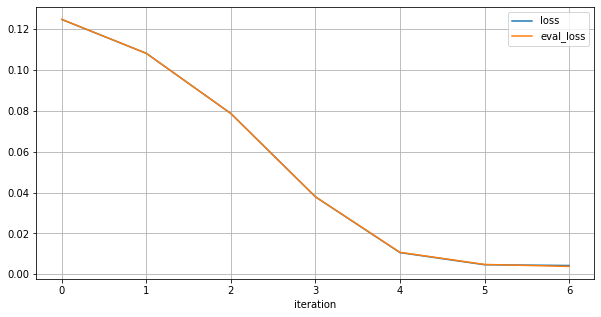

In [18]:
sql_training_info_model.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Step 4: Use the ML.EVALUATE function to evaluate the model data
The ML.EVALUATE function is used to evaluate model metrics. It reports the precision, recall, accuracy, f1_score, log_loss * roc_auc

Machine learning model evaluation metrics are used to

1. assess quality of fit between the model and the data,
2. compare different models, and
3. in the context of model selection, and to predict how accurate each model can be expected to perform on a specific data set.

Read the **BQML ML EVALUATE function** [doc](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate) reference

With the model created, you can now evaluate the logistic regression model. Behind the scenes, BigQuery ML automatically <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#data_split_method" target="_blank">split the data</a>, which makes it easier to quickly train and evaluate models.


In [25]:
sql_evaluate_model = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME})
"""

print(sql_evaluate_model)

run_bq_query(sql_evaluate_model)


SELECT
  *
FROM
  ML.EVALUATE(MODEL bqml_log_reg_chicago_crime_district_predict_model_dataset.bqml_log_reg_chicago_crime_district_predict_model)

Finished job_id: 52775f37-ce2f-416c-8bcc-e23e3be5b5aa


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.906009,0.906023,0.988012,0.905996,0.090927,0.91627


Another Query for getting evaluation metrics broken out by test, validate and training sets.


#### **Commentary**:
When evaluating model metrics, a rule of thumb is, what does 0 mean, what does 1 mean?

#### **F1_Score**:
This is the most [important](https://wiki.pathmind.com/accuracy-precision-recall-f1) metric IMO.

F1 is an overall measure of a model’s accuracy that combines *precision* and *recall*.

An F1 score is considered perfect when it’s 1, while the model is a total failure when it’s 0. In our model results, we have an F1 score of **90%** which is a good score.

#### **Precision**:
The percentage of predictions that were **correct (positive)**. The higher the precision, the fewer false positives predicted.

Here the model identified the `district` with a precision score of **0.90**, which meant that this model was correct *90%* of the time.

#### **Recall**:

The percentage of all ground truth items that were successfully predicted by the model.

The higher the recall, the fewer false negatives, or the fewer predictions missed.

Here the model identified the `district` recall score of **0.90** which means the model correctly classified 90% of all the census respondent buckets in the test data

##### **Accuracy**:
*How often is our model correct?*
- [What does a good accuracy score look like?](https://www.google.com/search?q=What+is+a+good+AUC+ROC+score%3F&ei=-f-UY-T3HYuNggff94GwCg&ved=0ahUKEwik2PL2hPD7AhWLhuAKHd97AKYQ4dUDCBA&uact=5&oq=What+is+a+good+AUC+ROC+score%3F&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIECAAQHjIFCAAQhgMyBQgAEIYDMgUIABCGAzIFCAAQhgMyBQgAEIYDOgcIABAeELADOggIABCGAxCwAzoGCAAQFhAeSgQIQRgBSgQIRhgAUFpY5wlggQxoAXAAeACAAWGIAeMBkgEBM5gBAKABAcgBBsABAQ&sclient=gws-wiz-serp) subjective but anything greater than 70% is a great model performance.

Accuracy is the fraction of predictions our model got right. This is the # of correct predictions (district correctly classified) over the Total # of predictions.

Here the model identified the `district` accuracy score of **0.98** which means the model correctly classified 98% of all the census respondent buckets in the test data

##### **Log_loss**:
[Log-loss](https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a#:~:text=Log%2Dloss%20is%20indicative%20of,is%20the%20log%2Dloss%20value) is indicative of how close the prediction probability is to the corresponding actual/true value. The more the predicted probability diverges from the actual value, the higher is the log-loss value.

Here the model has a log loss of **0.09** which means the prediction probability is close to the actual label when compared to the training data. The lower the log loss, the better the model.

##### **ROC_AUC**:
- [What does a good AUC ROC score look like?](https://www.google.com/search?q=What+is+a+good+AUC+ROC+score%3F&ei=-f-UY-T3HYuNggff94GwCg&ved=0ahUKEwik2PL2hPD7AhWLhuAKHd97AKYQ4dUDCBA&uact=5&oq=What+is+a+good+AUC+ROC+score%3F&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIECAAQHjIFCAAQhgMyBQgAEIYDMgUIABCGAzIFCAAQhgMyBQgAEIYDOgcIABAeELADOggIABCGAxCwAzoGCAAQFhAeSgQIQRgBSgQIRhgAUFpY5wlggQxoAXAAeACAAWGIAeMBkgEBM5gBAKABAcgBBsABAQ&sclient=gws-wiz-serp) Answer is between 0.8-0.9.

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings.

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

![AUC ROC](https://stephenallwright.com/content/images/2022/08/roc-auc-curve-diagram.png?ezimgfmt=rs:466x466/rscb1/ng:webp/ngcb1)


There are various metrics for logistic regression and other model types (full list of metrics can be found in the <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#mlevaluate_output" target="_blank">documentation</a>).

### Step 5: Use the ML.PREDICT function to predict the income bracket for a given set of census participants.

Finally, you use the [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict) function to predict the income bracket for a given set of census participants.

In [26]:
# Recap of what's in our view data.

# We can examine the view data using the sql below.
sql_examine_view_data = f"""
SELECT * FROM {BQ_DATASET_NAME}.input_view WHERE dataframe='prediction' limit 10;
"""

run_bq_query(sql_examine_view_data)

Finished job_id: 5f2199f8-08da-40dc-b480-615d5f22bb71


,district,location_description,arrest,date,block,primary_type,description,domestic,beat,ward,community_area,fbi_code,year,dataframe
0,5,APARTMENT,False,2009-05-02 03:15:00+00:00,105XX S WABASH AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,9,49,01A,2009,prediction
1,5,STREET,False,2009-05-31 02:00:00+00:00,105XX S INDIANA AVE,HOMICIDE,FIRST DEGREE MURDER,False,512,9,49,01A,2009,prediction
2,5,VEHICLE NON-COMMERCIAL,False,2009-05-06 12:00:00+00:00,0000X E 103RD PL,CRIM SEXUAL ASSAULT,AGGRAVATED: HANDGUN,False,512,9,49,02,2009,prediction
3,5,RESIDENCE,False,2009-08-21 08:00:00+00:00,007XX E 104TH ST,CRIM SEXUAL ASSAULT,PREDATORY,False,512,9,50,02,2009,prediction
4,5,APARTMENT,False,2019-08-04 01:24:00+00:00,007XX E 105TH PL,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,False,512,9,50,02,2019,prediction
5,5,APARTMENT,False,2019-06-19 04:00:00+00:00,009XX E 104TH ST,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,False,512,9,50,02,2019,prediction
6,5,STREET,False,2019-12-22 01:30:00+00:00,105XX S MARYLAND AVE,ROBBERY,ARMED: OTHER DANGEROUS WEAPON,False,512,9,50,03,2019,prediction
7,5,ALLEY,False,2009-04-15 07:06:00+00:00,103XX S VERNON AVE,ROBBERY,ARMED: HANDGUN,False,512,9,49,03,2009,prediction
8,5,RESIDENCE PORCH/HALLWAY,True,2009-09-17 09:00:00+00:00,104XX S CALUMET AVE,ROBBERY,ARMED: HANDGUN,False,512,9,49,03,2009,prediction
9,5,RESIDENCE,False,2019-06-19 07:34:00+00:00,106XX S LAFAYETTE AVE,ROBBERY,STRONGARM - NO WEAPON,True,512,34,49,03,2019,prediction


In [30]:
# We are using the remainder of our data ot perform predictions by limiting the dataframe to "PREDICTION". About 3142 rows.
sql_ml_predict = f"""
SELECT * FROM
 ML.PREDICT (MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME},
   (SELECT {MODEL_INPUT_COLUMNS},
    dataframe FROM {BQ_DATASET_NAME}.input_view
   WHERE dataframe = 'prediction')
 ) LIMIT 3
"""
print(sql_ml_predict)

run_bq_query(sql_ml_predict)


SELECT * FROM
 ML.PREDICT (MODEL bqml_log_reg_chicago_crime_district_predict_model_dataset.bqml_log_reg_chicago_crime_district_predict_model,
   (SELECT district,location_description,arrest,date,block,primary_type,description,domestic,beat,ward,community_area,fbi_code,year,
    dataframe FROM bqml_log_reg_chicago_crime_district_predict_model_dataset.input_view
   WHERE dataframe = 'prediction')
 ) LIMIT 3

Finished job_id: e3bef17f-744a-4332-b75f-e1b915f37223


,predicted_district,predicted_district_probs,district,location_description,arrest,date,block,primary_type,description,domestic,beat,ward,community_area,fbi_code,year,dataframe
0,31,"[{'label': 31, 'prob': 0.9896501812645535}, {'...",3,SMALL RETAIL STORE,False,2019-07-25 02:16:00+00:00,071XX S STATE ST,THEFT,RETAIL THEFT,False,323,6,69,06,2019,prediction
1,8,"[{'label': 8, 'prob': 0.9087442218947498}, {'l...",8,SIDEWALK,True,2009-11-05 01:52:25+00:00,073XX S KEDZIE AVE,NARCOTICS,POSS: CRACK,False,835,18,66,18,2009,prediction
2,16,"[{'label': 16, 'prob': 0.9721335274419127}, {'...",16,RESIDENCE,False,2009-01-02 07:20:00+00:00,070XX N ODELL AVE,CRIMINAL DAMAGE,TO PROPERTY,False,1611,41,9,14,2009,prediction



#### **Commentary**:
When the ML predict function runs, it generates 2 new columns. These are:
1. predicted_district
1. predicted_district_probs

The `predicted_district` has the classfication predictions of the original `arrest` label.

The `predicted_district_probs` contains the probability scores for each of the binary options.

Lets take a look at **row 3 **who's prediction results are as follows:
```
predicted_district = 16
predicted_district_probs	=
{'label': True, 'prob': 0.07343320259354878}
{'label': False, 'prob': 0.9265667974064512}
district = 16,
```
The model's district probability was 97.2% for 16, and and every other district with 2.8% based on the inputs provided. This matched the dataset original label.

```
date = 2009-01-02 07:20:00+00:00
block = 070XX N ODELL AVE
primary_type = CRIMINAL_DAMAGE
description = ARMED: TO PROPERTY
location_description = RESIDENCE
domestic = false
beat = 1611
district = 16
ward = 41
community_area = 9
fbi_code = 14
year = 2009

```

In [31]:
print(MODEL_INPUT_COLUMNS)

district,location_description,arrest,date,block,primary_type,description,domestic,beat,ward,community_area,fbi_code,year


### Step 6: Use the ML.EXPLAIN_PREDICT function to know which features are the most important to determine the weight

To understand why the model is generating these prediction results, you can use the ML.EXPLAIN_PREDICT function.


<a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict" target="_blank">ML.EXPLAIN_PREDICT</a> has built-in <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview" target="_blank">Explainable AI</a>. This allows you to see the top contributing features to each prediction and interpret how it was computed.

In [32]:
sql_explain_predict = f"""

SELECT * FROM
ML.EXPLAIN_PREDICT(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME},
 (
  SELECT {MODEL_INPUT_COLUMNS},
  dataframe FROM {BQ_DATASET_NAME}.input_view
  WHERE dataframe = 'prediction'),
  STRUCT(5 as top_k_features)
 ) LIMIT 3
"""

run_bq_query(sql_explain_predict)

Finished job_id: 1d2f658c-b6b9-4897-bf14-c6e53ea7a7fc


,predicted_district,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,district,location_description,arrest,date,block,primary_type,description,domestic,beat,ward,community_area,fbi_code,year,dataframe
0,8,0.933383,"[{'feature': 'block', 'attribution': 4.5601263...",0.043606,5.722843,0.0,8,PARK PROPERTY,False,2009-08-13 06:14:00+00:00,029XX W 85TH ST,BATTERY,DOMESTIC BATTERY SIMPLE,False,835,18,70,08B,2009,prediction
1,8,0.944421,"[{'feature': 'block', 'attribution': 4.4682180...",0.043606,5.926143,0.0,8,RESIDENCE,False,2009-07-21 12:00:00+00:00,080XX S CALIFORNIA AVE,BURGLARY,FORCIBLE ENTRY,False,835,18,70,05,2009,prediction
2,3,0.948165,"[{'feature': 'block', 'attribution': 5.1219970...",0.019461,6.011289,0.0,3,STREET,False,2009-05-03 06:20:00+00:00,073XX S EAST END AVE,BATTERY,SIMPLE,False,324,8,43,08B,2009,prediction



#### **Commentary**:
![AUC ROC](https://github.com/paulycloud/ml_portfolio/blob/main/02_BigQuery_ML/02_census_logistic_reg/assets/ml_explain_predict.png?raw=true)

When the ML.EXPLAIN_PREDICT function runs, it generates 6 new columns. These are:
1. predicted_district
1. probability
1. top_feature_attributions
1. baseline_prediction_value
1. prediction_value
1. approximation_error

Lets take a look at **row 3** who's prediction results are as follows:

```
predicted_district = 3
probability=0.948165
top_feature_attributions= ['block', 'beat','ward','date']
baseline_prediction_value=0.019461108544303836
prediction_value=6.011289149474828
approximation_error=0

date = 2009-05-03 06:20:00+00:00
block = 073XX S EAST END AVE
primary_type = BATTERY
description = SIMPLE
location_description = STREET
domestic = false
arrest = false
beat = 512
district = 3
ward = 8
community_area = 43
fbi_code = 08B
year = 2009
```

The `predicted_district` has the classfication predictions of the original `district` label. In this case, its 3

The `probability` contains the probability scores for each of the binary options in this case its 94%.

The `top_feature_attributions` this is an array containing the 3 top features contributng to the prediction. In this case, Education_num, marital_status and age are the top factors.

The `baseline_prediction_value` is the mean across all numerical features and NULL for other types of features.

The `prediction_value` contains the probability scores for each of the binary options.

The `approximation_error` The exact attribution methods like Tree SHAP have the property such that baseline_prediction_value + {sigma} feature_attribution


### Step 7: Inspect the model on Vertex AI Model Registry

When the model was trained in BigQuery ML, the line `model_registry="vertex_ai"` registered the model to Vertex AI Model Registry automatically upon completion.

You can view the model on the <a href="https://console.cloud.google.com/vertex-ai/models" target="_blank">Vertex AI Model Registry page</a>, or use the code below to check that it was successfully registered:

In [33]:
model = vertex_ai.Model(model_name=BQML_MODEL_NAME)
print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{BQML_MODEL_NAME}?project={PROJECT_ID}')

print(model.gca_resource)



Review the Model in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_log_reg_chicago_crime_district_predict_model?project=paulkamau
name: "projects/993987777814/locations/us-central1/models/bqml_log_reg_chicago_crime_district_predict_model"
display_name: "bqml_log_reg_chicago_crime_district_predict_model"
supported_deployment_resources_types: DEDICATED_RESOURCES
supported_input_storage_formats: "jsonl"
supported_input_storage_formats: "bigquery"
supported_input_storage_formats: "csv"
supported_input_storage_formats: "tf-record"
supported_input_storage_formats: "tf-record-gzip"
supported_input_storage_formats: "file-list"
supported_output_storage_formats: "jsonl"
supported_output_storage_formats: "bigquery"
create_time {
  seconds: 1674059758
  nanos: 353997000
}
update_time {
  seconds: 1674059831
  nanos: 445233000
}
etag: "AMEw9yO1r1MGEN2HOcUWoZvtwu0medT1dJE_ZYkkmcCfbw8DAorek8Is-LOYxVzp48hO"
version_id: "1"
version_aliases: "logistic_reg"
vers

### Step 8: Create the endpoint and Deploy the model to an endpoint
Endpoints are machine learning models made available for online prediction requests. Endpoints are useful for timely predictions from many users (for example, in response to an application request). You can also request batch predictions if you don't need immediate results.

While BigQuery ML supports batch prediction with <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict" target="_blank">ML.PREDICT</a> and <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict" target="_blank">ML.EXPLAIN_PREDICT</a>, BigQuery ML is not suitable for real-time predictions where you need low latency predictions with potentially high frequency of requests.

In other words, deploying the BigQuery ML model to an endpoint enables you to do online predictions.


#### Create a Vertex AI endpoint
To deploy your model to an endpoint, you will first need to create an endpoint before you deploy the model to it.

In [34]:
# create an endpoint if it doesn't exist
endpoints = vertex_ai.Endpoint.list(filter = f"display_name={BQML_ENDPOINT_NAME}")

if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].display_name}")
else:
    endpoint = vertex_ai.Endpoint.create(
    display_name=BQML_ENDPOINT_NAME,
    location=REGION,
    project=PROJECT_ID,
    )
    print(f"Endpoint Created: {endpoint.display_name}")

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

print(endpoint.display_name)
print(endpoint.resource_name)

Creating Endpoint


INFO:google.cloud.aiplatform.models:Creating Endpoint


Create Endpoint backing LRO: projects/993987777814/locations/us-central1/endpoints/393453638929874944/operations/7421889098794663936


INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/993987777814/locations/us-central1/endpoints/393453638929874944/operations/7421889098794663936


Endpoint created. Resource name: projects/993987777814/locations/us-central1/endpoints/393453638929874944


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/993987777814/locations/us-central1/endpoints/393453638929874944


To use this Endpoint in another session:


INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/993987777814/locations/us-central1/endpoints/393453638929874944')


INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/993987777814/locations/us-central1/endpoints/393453638929874944')


Endpoint Created: bqml_log_reg_chicago_crime_district_predict_model_endpoint
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/393453638929874944?project=paulkamau
bqml_log_reg_chicago_crime_district_predict_model_endpoint
projects/993987777814/locations/us-central1/endpoints/393453638929874944


#### Deploy model to Vertex endpoint

With the new endpoint, you can now deploy your model.

In [35]:
# deploying the model to the endpoint may take 10-15 minutes
# Check if Model Deployment Exists
deployments = vertex_ai.Endpoint.list(filter = f"display_name={BQML_ENDPOINT_NAME}")

if deployments:
    deployment = deployments[0]
    print(f"Deployment Exists: {deployments[0].display_name}")
else:
    model.deploy(endpoint=endpoint)
    print(f"Model deployment Created: {endpoint.display_name}")

Deployment Exists: bqml_log_reg_chicago_crime_district_predict_model_endpoint


You can also check on the status of your model by visiting the <a href="https://console.cloud.google.com/vertex-ai/endpoints" target="_blank">Vertex AI Endpoints page</a>.

### Step 9: Make online predictions to the endpoint

Using a sample of the training data, you can test the endpoint to make online predictions.

In [ ]:
df_sample_requests_list = [
    {
      "date":"2009-04-19 01:30:00+00:00",
      "block":"106XX S WABASH AVE",
      "primary_type":"PUBLIC PEACE VIOLATION",
      "description":"RECKLESS CONDUCT",
      "location_description":"SIDEWALK",
      "domestic":"false",
      "beat":512,
      "arrest":"false",
      "ward":34,
      "community_area":49,
      "fbi_code": "09",
      "year":2023,
    },
]

In [ ]:
prediction = endpoint.predict(df_sample_requests_list)
print(prediction)

You can then extract the predictions from the prediction response

In [ ]:
# to view the prediction for the first row
prediction.predictions[1]['predicted_district']

## Cleaning up

To clean up all Google Cloud resources used in this project, you can <a href="https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects" target="_blank">delete the Google Cloud
project</a> you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# Undeploy model from endpoint and delete endpoint
endpoint.undeploy_all()
endpoint.delete()

# Delete BigQuery dataset, including the BigQuery ML model
#! bq rm -r -f $PROJECT_ID:$BQ_DATASET_NAME